# Para trabajar con Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/Artificial Intelligence/IA 2019-2 Proyecto Final/Notebook' 
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Artificial Intelligence/IA 2019-2 Proyecto Final/Notebook
/content/drive/My Drive/Artificial Intelligence/IA 2019-2 Proyecto Final/Notebook


# Importando librerías

In [0]:
!pip install pysoundfile
!apt-get install libav-tools -y
!apt-get install zip
!pip freeze > '../working/dockerimage_snapshot.txt'
!pip install wordcloud
!pip install -q tensorflow-hub
!pip install -q tfds-nightly

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package libav-tools is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source
However the following packages replace it:
  ffmpeg

E: Package 'libav-tools' has no installation candidate
Reading package lists... Done
Building dependency tree       
Reading state information... Done
zip is already the newest version (3.0-11build1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
/bin/bash: ../working/dockerimage_snapshot.txt: No such file or directory
     |████████████████████████████████| 3.3MB 2.7MB/s 


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  !pip install -q tf-nightly
except Exception:
  pass
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

import librosa
import librosa.display as dis
# import soundfile as sf
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import IPython
import os
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import image
import pylab
import gc
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import nltk
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from datetime import datetime
import io
import itertools
from packaging import version
from six.moves import range
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output
from fastai.vision import *

     |████████████████████████████████| 517.6MB 29kB/s 
     |████████████████████████████████| 3.0MB 56kB/s 
     |████████████████████████████████| 460kB 57.7MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Proyecto: Identificación de dolencias a partir de información dada en audio y texto
**Integrantes**


1.   Emmanuel David Martínez Estrada
2.   Laura Daniela Serrano Villanova
3.   María Paula Riveros Gómez



# Motivación

Este proyecto recopila información en audio y texto de pacientes las cuales contienen descripciones de los sintomas que presentan, con el proposito de determinar el tipo de dolencia que tiene exactamente.


# Objetivos


*   Clasificar dolencias a partir de textos.
*   Clasificar dolencias a partir de audios.



# Cargando dataset (Texto y audio)

Nuestro dataset es el siguiente:

In [3]:
PATH = '../Data/recordings-overview.csv'
overview = pd.read_csv(PATH)
overview.head(20)

,audio_clipping,audio_clipping:confidence,background_noise_audible,background_noise_audible:confidence,overall_quality_of_the_audio,quiet_speaker,quiet_speaker:confidence,speaker_id,file_download,file_name,phrase,prompt,writer_id
0,no_clipping,1.0000,light_noise,1.0000,3.33,audible_speaker,1.0000,43453425,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43453425_58166571.wav,When I remember her I feel down,Emotional pain,21665495
1,light_clipping,0.6803,no_noise,0.6803,3.33,audible_speaker,1.0000,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43719934_43347848.wav,When I carry heavy things I feel like breaking...,Hair falling out,44088126
2,no_clipping,1.0000,no_noise,0.6655,3.33,audible_speaker,1.0000,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43719934_53187202.wav,there is too much pain when i move my arm,Heart hurts,44292353
3,no_clipping,1.0000,light_noise,1.0000,3.33,audible_speaker,1.0000,31349958,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_31349958_55816195.wav,My son had his lip pierced and it is swollen a...,Infected wound,43755034
4,no_clipping,1.0000,no_noise,1.0000,4.67,audible_speaker,1.0000,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43719934_82524191.wav,My muscles in my lower back are aching,Infected wound,21665495
5,no_clipping,1.0000,no_noise,1.0000,3.00,audible_speaker,1.0000,40663048,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_40663048_51348478.wav,i have muscle pain that my back\nI Have Muscle...,Foot ache,44130352
6,no_clipping,1.0000,no_noise,1.0000,3.67,audible_speaker,1.0000,40663048,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_40663048_42741720.wav,I have muscle pain in my left leg,Shoulder pain,43913997
7,no_clipping,1.0000,no_noise,1.0000,4.25,audible_speaker,1.0000,15004831,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_15004831_21919890.wav,I have cut my finger because of playing footba...,Injury from sports,43318517
8,no_clipping,0.6978,no_noise,1.0000,3.67,audible_speaker,1.0000,14353703,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_14353703_93481996.wav,I have acne in my face and other problems in m...,Skin issue,44066678
9,no_clipping,1.0000,no_noise,0.6879,3.33,audible_speaker,1.0000,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43719934_85316490.wav,I have a strange rash on my arm,Foot ache,44130352


Necesitamos definir nuestro conjunto de datos tanto para texto como para audio, por lo que se seleccionarán las columnas file_name y phrase del dataset respectivamente, y el target será la columna prompt para los dos cojuntos de datos.


In [0]:
overview = overview[['file_name','phrase','prompt','overall_quality_of_the_audio','speaker_id']]
class_names = pd.unique(overview['prompt'])
overview['target'] = pd.Series(data=np.array([np.argwhere(prompt == class_names) for prompt in overview['prompt']]).squeeze())

overview = overview.dropna()
overviewAudio = overview[['file_name','prompt','target']]
overviewText = overview[['phrase','prompt','target']]

noNaNcsv = PATH
noNaNcsv = pd.read_csv(noNaNcsv)
noNaNcsv = noNaNcsv.dropna()
noNaNcsv = noNaNcsv.to_csv(PATH, index=False)
noNaNcsv

Mostramos el nombre de nuestras clases:

In [5]:
print('Cantidad de clases: {}'.format(len(class_names)))
print('Clases (target): {}'.format(class_names))

Cantidad de clases: 25
Clases (target): ['Emotional pain' 'Hair falling out' 'Heart hurts' 'Infected wound' 'Foot ache' 'Shoulder pain' 'Injury from sports'
 'Skin issue' 'Stomach ache' 'Knee pain' 'Joint pain' 'Hard to breath' 'Head ache' 'Body feels weak' 'Feeling dizzy'
 'Back pain' 'Open wound' 'Internal pain' 'Blurry vision' 'Acne' 'Muscle pain' 'Neck pain' 'Cough' 'Ear ache'
 'Feeling cold']


**Visualización y análisis de datos**

El dataset consiste de descripciones verbales de sintomas medicos (.wav, audio) y su respectiva transcripción de texto (.csv, datos de texto) y una etiqueta de acuerdo con la categoria del malestar (prompt)

Aqui tenemos una pequeña muestra todos nuestros datos de interés del dataset original.

In [6]:
overview.head()

,file_name,phrase,prompt,overall_quality_of_the_audio,speaker_id,target
0,1249120_43453425_58166571.wav,When I remember her I feel down,Emotional pain,3.33,43453425,0
1,1249120_43719934_43347848.wav,When I carry heavy things I feel like breaking...,Hair falling out,3.33,43719934,1
2,1249120_43719934_53187202.wav,there is too much pain when i move my arm,Heart hurts,3.33,43719934,2
3,1249120_31349958_55816195.wav,My son had his lip pierced and it is swollen a...,Infected wound,3.33,31349958,3
4,1249120_43719934_82524191.wav,My muscles in my lower back are aching,Infected wound,4.67,43719934,3


# Datasets definidos para la clasificacion de texto y audio

In [7]:
overviewText.head()

,phrase,prompt,target
0,When I remember her I feel down,Emotional pain,0
1,When I carry heavy things I feel like breaking...,Hair falling out,1
2,there is too much pain when i move my arm,Heart hurts,2
3,My son had his lip pierced and it is swollen a...,Infected wound,3
4,My muscles in my lower back are aching,Infected wound,3


In [8]:
overviewAudio.head()

,file_name,prompt,target
0,1249120_43453425_58166571.wav,Emotional pain,0
1,1249120_43719934_43347848.wav,Hair falling out,1
2,1249120_43719934_53187202.wav,Heart hurts,2
3,1249120_31349958_55816195.wav,Infected wound,3
4,1249120_43719934_82524191.wav,Infected wound,3


# Análisis estadístico

Describimos las clases de las dolencias de las descripciones de audio, donde se hará a partir del dataset completo (6661 registros)

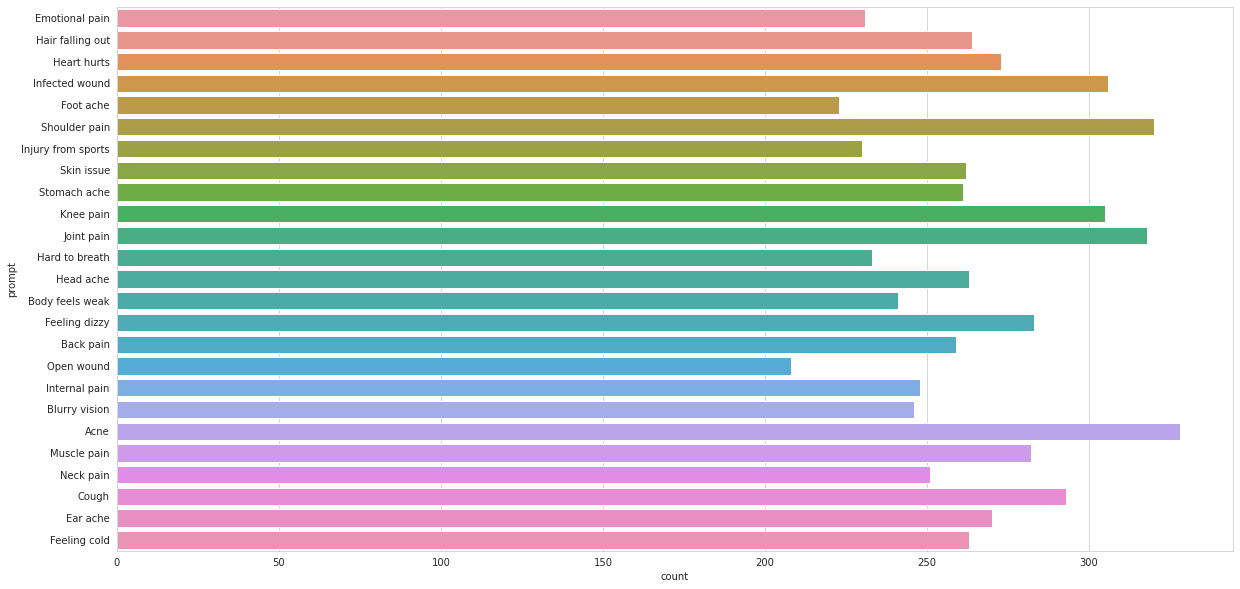

In [0]:
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
promptsPlot = sns.countplot(y='prompt',data=overview)
promptsPlot

Ahora con la libreria de WordCloud mostraremos las palabras más comunes que se encuentran en las descripciones de texto:

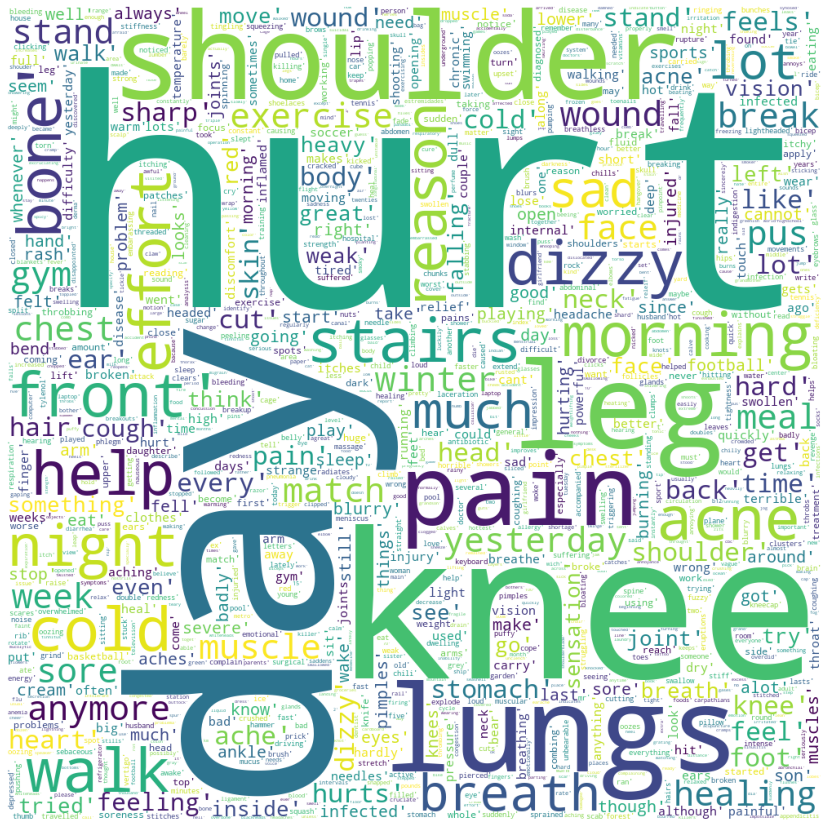

In [0]:
plt.figure(figsize=(15,15))
topic_words = [ z.lower() for y in [ x.split() for x in overview['phrase'] if isinstance(x, str)] for z in y]
word_count_dict = dict(Counter(topic_words))
popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
word_string=str(popular_words_nonstop)
wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', max_words=1000000, width=1000,height=1000,).generate(word_string)
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

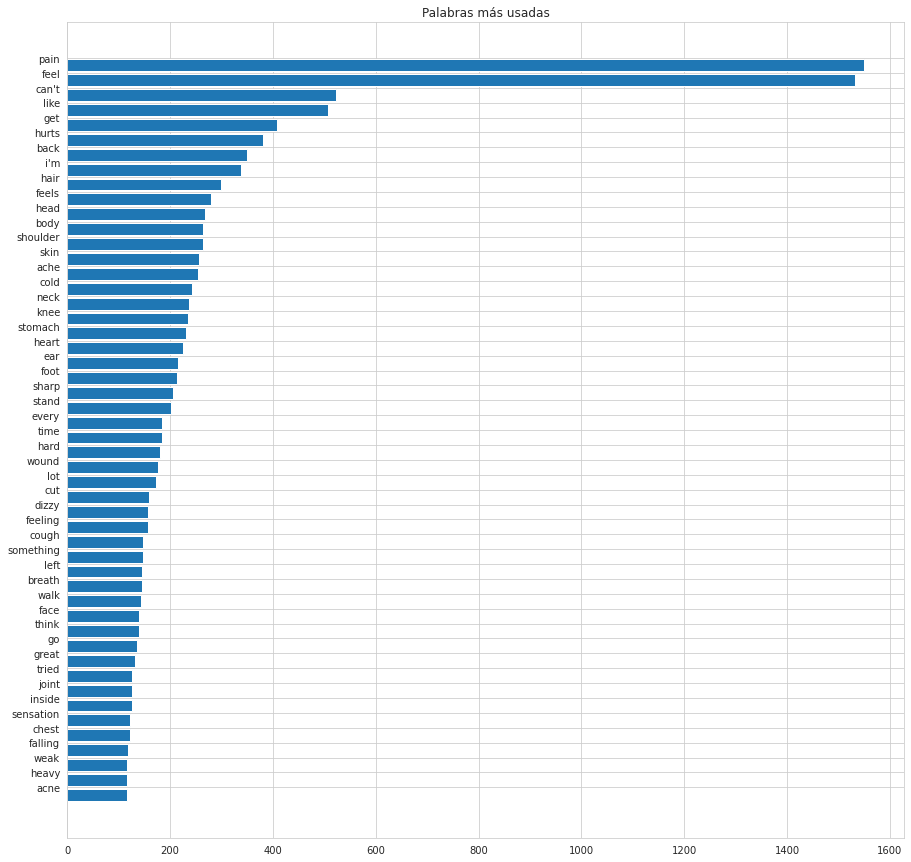

In [0]:
plt.figure(figsize=(15,15))
word_count_dict = dict(Counter(topic_words))
popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:50])])
plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words_nonstop[0:50]))
plt.title('Palabras más usadas')
plt.show()

# Clasificación de texto

Esta clasificación de texto entrena una red neuronal basandose en los síntomas categorizados de diferentes pacientes.


In [0]:
encoder = tfds.features.text.SubwordTextEncoder.build_from_corpus(overviewText['phrase'].to_string(), target_vocab_size=2**15)
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 257



Este codificador de texto codificará, de forma reversible, cualquier string, usando codificación por bytes si es necesario.

In [0]:
sample_string = 'I have a headache.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [74, 33, 105, 98, 119, 102, 33, 98, 33, 105, 102, 98, 101, 98, 100, 105, 102, 47]
The original string: "I have a headache."


In [0]:
assert original_string == sample_string

for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

74 ----> I
33 ---->  
105 ----> h
98 ----> a
119 ----> v
102 ----> e
33 ---->  
98 ----> a
33 ---->  
105 ----> h
102 ----> e
98 ----> a
101 ----> d
98 ----> a
100 ----> c
105 ----> h
102 ----> e
47 ----> .


Usamos el método padded_batch para poner a cero las secuencias a la longitud de la cadena más larga del lote

In [0]:
def padded_batch(data, pad_size=64):
    if len(data) > pad_size:
        return data[:pad_size]
    else:
        return np.r_[data, np.zeros(pad_size - len(data))]

In [0]:
data = np.array([encoder.encode(phrase) for phrase in overviewText['phrase']])
padd_size = len(np.max(data))
data = np.array([padded_batch(dt, padd_size) for dt in data])

Creando el dataset de train, test y validate

In [0]:
target = tf.keras.utils.to_categorical(overviewText['target'], num_classes=25, dtype='float32')
train_dataset = tf.data.Dataset.from_tensor_slices((data[:-600, :], target[:-600]))
test_dataset = tf.data.Dataset.from_tensor_slices((data[-600:-300, :], target[-600:-300]))
validate_dataset = tf.data.Dataset.from_tensor_slices((data[-300:, :], target[-300:]))

X_test, y_test = data[-600:-300, :], target[-600:-300]

print('Train:    {}'.format(train_dataset))
print('Test:     {}'.format(test_dataset))
print('Validate: {}'.format(validate_dataset))

Train:    <TensorSliceDataset shapes: ((53,), (25,)), types: (tf.float64, tf.float32)>
Test:     <TensorSliceDataset shapes: ((53,), (25,)), types: (tf.float64, tf.float32)>
Validate: <TensorSliceDataset shapes: ((53,), (25,)), types: (tf.float64, tf.float32)>


### Preparación para el entrenamiento

In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [0]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)

train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_dataset.padded_batch(BATCH_SIZE)
validate_dataset = validate_dataset.padded_batch(BATCH_SIZE)

print(train_dataset, test_dataset, validate_dataset)

<PaddedBatchDataset shapes: ((None, 53), (None, 25)), types: (tf.float64, tf.float32)> <PaddedBatchDataset shapes: ((None, 53), (None, 25)), types: (tf.float64, tf.float32)> <PaddedBatchDataset shapes: ((None, 53), (None, 25)), types: (tf.float64, tf.float32)>


**Creando un modelo**

In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(53,)),  # input shape required
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dense(25, activation=tf.nn.softmax)
])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               6912      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1625      
Total params: 16,793
Trainable params: 16,793
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

**Entrenando el modelo**

In [0]:
history = model.fit(train_dataset,
                    epochs=200,
                    validation_data=validate_dataset)

Epoch 1/200
95/95 [==============================] - 0s 5ms/step - loss: 41.2352 - accuracy: 0.0502 - val_loss: 24.0743 - val_accuracy: 0.0633
Epoch 2/200
95/95 [==============================] - 0s 3ms/step - loss: 17.8019 - accuracy: 0.0660 - val_loss: 14.5888 - val_accuracy: 0.0667
Epoch 3/200
95/95 [==============================] - 0s 3ms/step - loss: 11.4915 - accuracy: 0.0678 - val_loss: 9.4543 - val_accuracy: 0.0667
Epoch 4/200
95/95 [==============================] - 0s 3ms/step - loss: 6.4859 - accuracy: 0.0685 - val_loss: 4.6648 - val_accuracy: 0.0867
Epoch 5/200
95/95 [==============================] - 0s 3ms/step - loss: 4.0573 - accuracy: 0.0629 - val_loss: 3.5064 - val_accuracy: 0.0867
Epoch 6/200
95/95 [==============================] - 0s 3ms/step - loss: 3.4547 - accuracy: 0.0551 - val_loss: 3.1809 - val_accuracy: 0.0967
Epoch 7/200
95/95 [==============================] - 0s 3ms/step - loss: 3.2447 - accuracy: 0.0594 - val_loss: 3.0986 - val_accuracy: 0.0867
Epoch 8/

In [0]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

5/5 [==============================] - 0s 2ms/step - loss: 0.1924 - accuracy: 0.9333
Test Loss: 0.19238120317459106
Test Accuracy: 0.9333333373069763


Ahora trazamos un mapa de confusión para apreciar mejor la precisión de la reconstrucción con respecto al target.

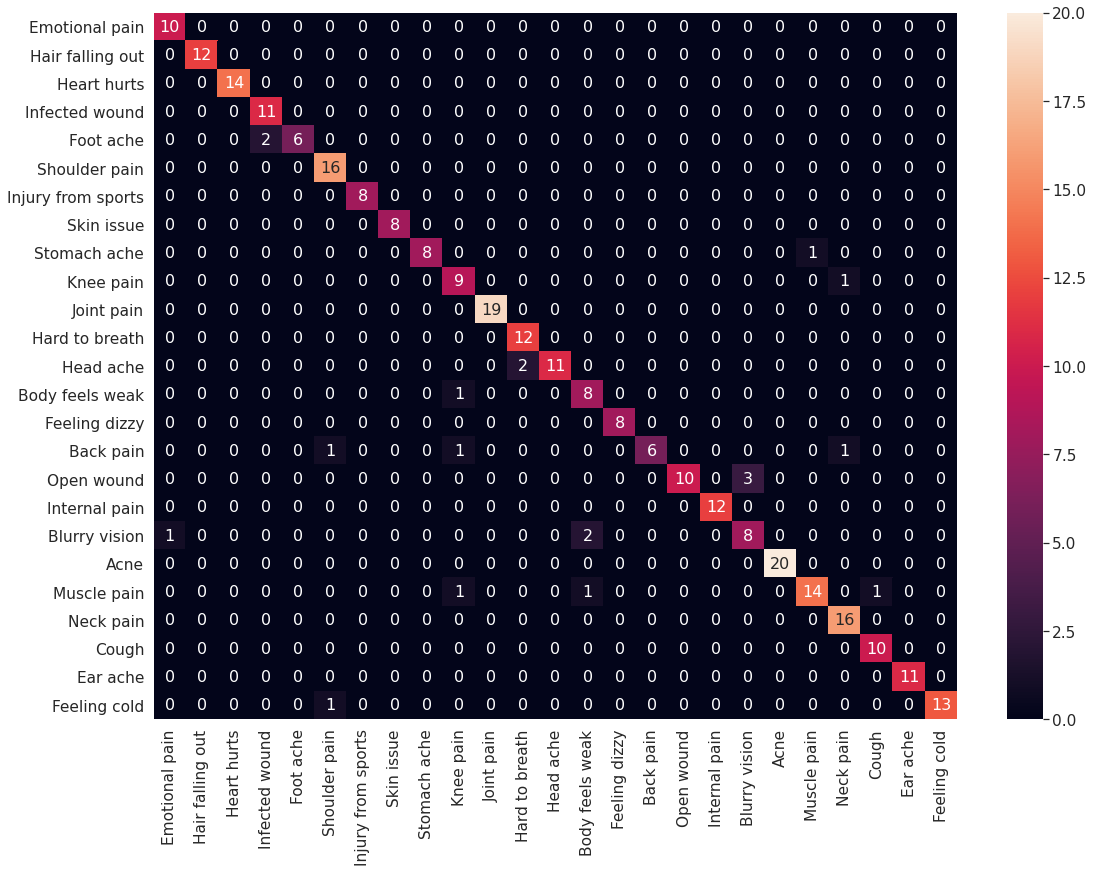

In [0]:
y_predict = model.predict(X_test)
cm = np.array(tf.math.confusion_matrix(labels=np.argmax(y_test, axis=1), predictions=np.argmax(y_predict, axis=1)))

df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(18,13))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

Podemos concluir de esta clasificación de texto que es bastante buena.

# Clasificación de audio

Visualizaremos los espectros de audio que se usarán en una sola gráfica

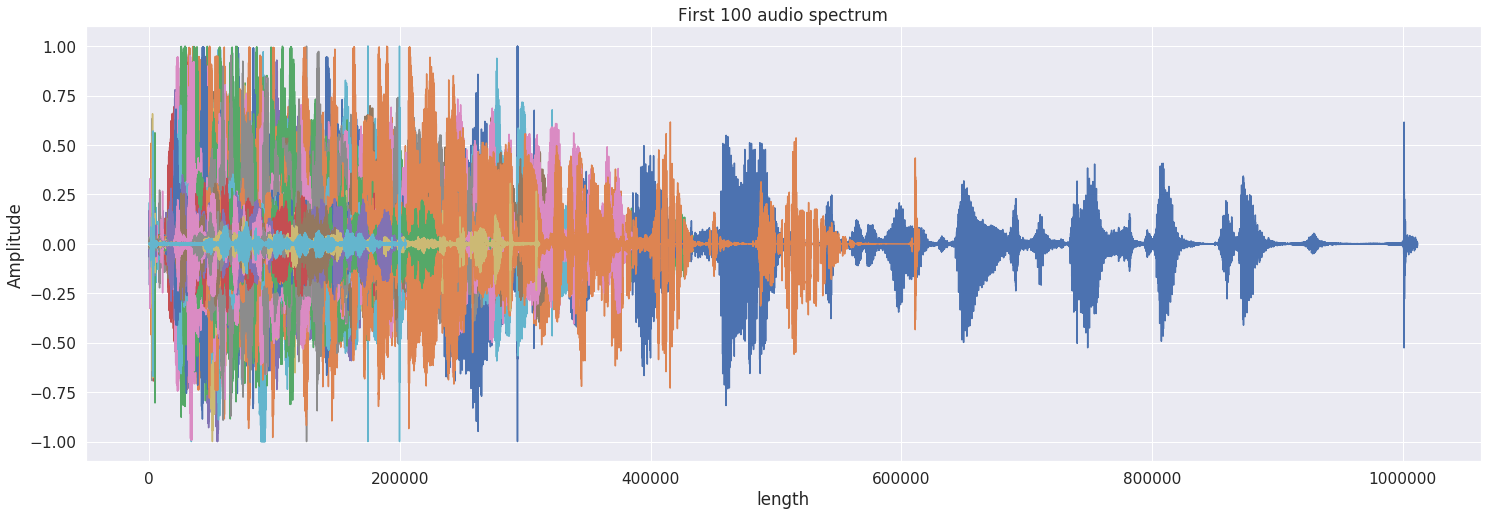

In [0]:
plt.figure(figsize=(25,8))
for i, filename in enumerate(overviewAudio['file_name'][:100].values):
  wav, _ = librosa.load('../Data/Train/' + filename, sr=None)
  plt.plot(wav)
  print('wav #{}'.format(i))
  if i % 20 == 0:
    clear_output()

plt.title(label='First 100 audio spectrum')
plt.xlabel('length')
plt.ylabel('Amplitude')
clear_output()

(1025, 240) (246000,)


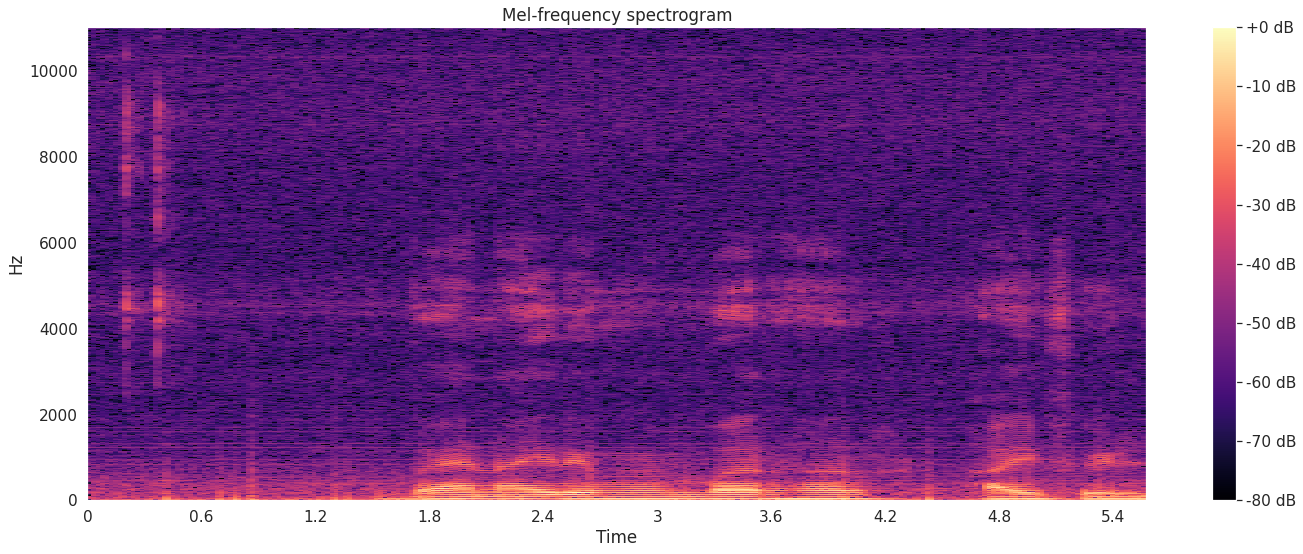

In [0]:
wav, sr = librosa.load('../Data/Train/' + overviewAudio['file_name'][0], sr=None)
D = librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max)
print (D.shape, D.reshape(D.shape[0]*D.shape[1]).shape)
plt.figure(figsize=(20, 8))
dis.specshow(D, y_axis='linear', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

# Creando el dataset

Obtenemos todos los espectros y los guardamos en un folder, en este caso se llamará ***melspectrograms***.

In [0]:
data_dir_train = np.array(glob('../Data/Train/*'))
data_dir_test = np.array(glob('../Data/Test/*'))
data_dir_validate = np.array(glob('../Data/Validate/*'))

In [0]:
def create_melspectrogram(iteration, filename, name):
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    filename  = Path('../Data/melspectrograms/' + name + '.jpg')
    plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    print(i, file)
    if i % 20 == 0:
        clear_output()
        
    del filename, name, clip, sample_rate, fig, ax, S

In [0]:
for i, file in enumerate(data_dir_train):
    create_melspectrogram(i, file, file.split('/')[-1].split('.')[0])
print('Ya se crearon todas las imagenes de entrenamiento')

for i, file in enumerate(data_dir_test):
    create_melspectrogram(i, file, file.split('/')[-1].split('.')[0])
print('Ya se crearon todas las imagenes de prueba')

for i, file in enumerate(data_dir_validate):
    create_melspectrogram(i, file, file.split('/')[-1].split('.')[0])
print('Ya se crearon todas las imagenes de validación')

## Cargando datos y entrenando el modelo

Antes de cargar los datos es necesario reajustar overviewAudio

In [10]:
overviewAudio = overview[['file_name','prompt']]
overviewAudio['spec_name'] = overviewAudio['file_name'].str.rstrip('.wav')
overviewAudio = overviewAudio[['spec_name','prompt']]
overviewAudio.head()

,spec_name,prompt
0,1249120_43453425_58166571,Emotional pain
1,1249120_43719934_43347848,Hair falling out
2,1249120_43719934_53187202,Heart hurts
3,1249120_31349958_55816195,Infected wound
4,1249120_43719934_82524191,Infected wound


Ahora usaremos la librería de fastai para realizar el entrenamiento a través de un red neuronal predeterminada, es importante realizar un pequeño entrenamiento con la red neuronal "congelada", es decir, peso de capas no entrenables para que la red se adapte a nuestro dataset mejor.

In [35]:
data = ImageDataBunch.from_df(Path('.'),df=overviewAudio, folder="../Data/melspectrograms", valid_pct=0.2, suffix='.jpg',
        ds_tfms=get_transforms(), size=299, num_workers=0).normalize(imagenet_stats)
learn = create_cnn(data, models.resnet50, metrics=accuracy)
learn.fit_one_cycle(10)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy,time
0,4.738070,3.796345,0.045045,32:28
1,4.326355,3.655918,0.051051,01:53
2,3.856716,3.469635,0.057057,01:50
3,3.564278,3.359322,0.062312,01:49
4,3.382643,3.329995,0.081832,01:49
5,3.269004,3.278073,0.074324,01:49
6,3.172305,3.250325,0.081832,01:48
7,3.078789,3.221881,0.078829,01:49
8,3.008877,3.221519,0.081832,01:49
9,2.963793,3.222696,0.084084,01:48


Ahora descongelamos las capas para poder entrenar sus pesos, calculamos la tasa de aprendizaje para mejor visualización y graficamos este resultado.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


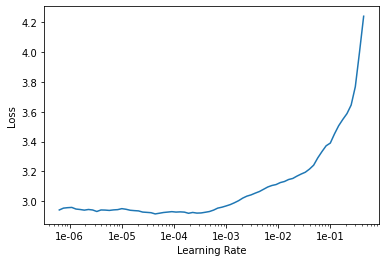

In [36]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

Finalmente, entrenamos la red.

In [37]:
learn.fit_one_cycle(50)

epoch,train_loss,valid_loss,accuracy,time
0,2.961338,3.212404,0.096096,02:01
1,2.930842,3.209820,0.090841,02:02
2,2.876735,3.215971,0.092342,02:01
3,2.831060,3.242888,0.090841,02:02
4,2.790399,3.268062,0.107357,02:01
5,2.757057,3.361820,0.087838,02:01
6,2.741490,3.264112,0.114114,02:01
7,2.708029,3.433064,0.113363,02:01
8,2.669854,3.317489,0.109610,02:01
9,2.662106,3.254663,0.120871,02:01


Al igual que hicimos con la clasificación del texto, haremos una matriz de confusión para la clasificación de los audios.

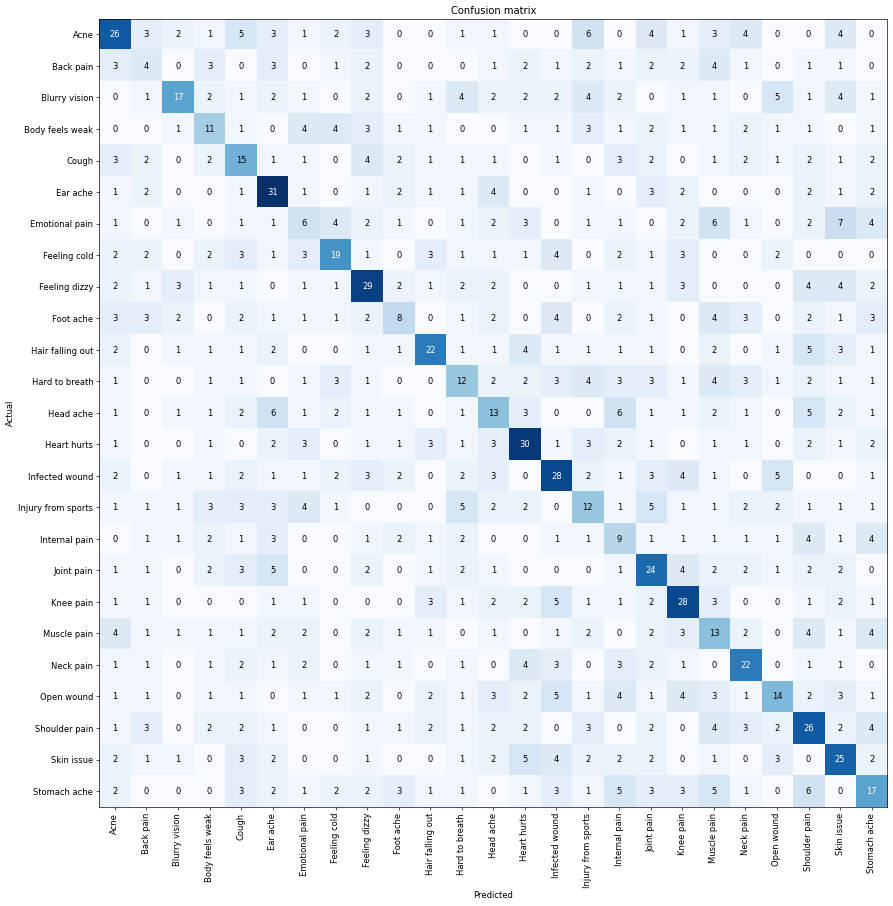

In [38]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(23,15), dpi=60)

# Conclusiones

Finalmente, no solo hemos podido clasificar los sintomas por texto sino tambien por audio, y mostramos que mediante el uso de redes neuronales se puede obtener una precisión superior a otros tipos de métodos más primitivos.

Es importante tener en cuenta que la presición en la clasificación se debe esencialmente a la calidad del dataset, en el caso de los textos la recontrucción fue muy buena ya que muchas de las palabras que decian los pacietnes se repetian, permitiendo generar un patrón de reconstrucción más solido que la clasificación por audios, donde habian muchos audios con ruido, recortados, malas pronunciaciones entre otros.